In [14]:
import time
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle
import torch as torch
import torchvision
import mongoengine as mo
from torchvision import transforms
from torchvision import datasets

In [15]:
try:
    from configcarrot import *
except ImportError:
    login = '' # Please provide your login to MongoDB
    password = '' # Please provide your password to MongoDB
    host = '' # Please provide your host name to MongoDB


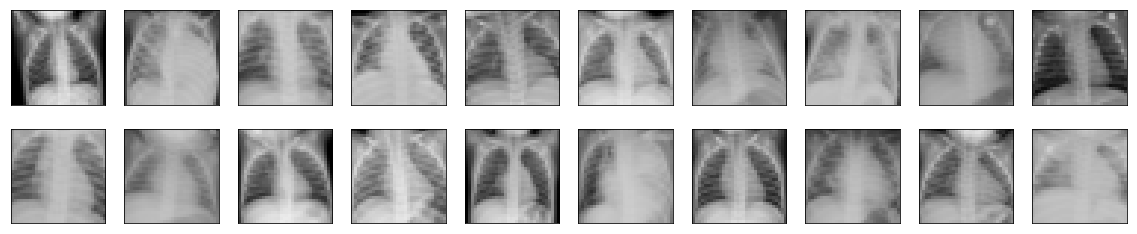

In [16]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [17]:
image_transforms = {'train': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
                  }

loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=image_transforms['train']),
                                                        batch_size=128, shuffle=True),                    
                   'valid': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/val', 
                                                                             transform=image_transforms['valid']),
                                                        batch_size=128, shuffle=True), 
                   'test': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/test', 
                                                                            transform=image_transforms['test']),
                                                        batch_size=128, shuffle=True)}

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=6272, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=412)
        self.fc4 = nn.Linear(in_features=412, out_features=2)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(F.max_pool2d(self.c1(x), 3))
        x = F.relu(F.max_pool2d(self.c2(x), 3))
        x = F.relu(F.max_pool2d(self.c3(x), 3))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


In [19]:
model = Net()

In [20]:
model.cuda()

Net(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=2, bias=True)
)

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [22]:
mo.disconnect_all()

In [23]:
mo.connect(host='mongodb+srv://' + login + ':' + password + '@' + host,
           authentication_source='admin')

MongoClient(host=['andreiliphd-shard-00-01-tvi0s.mongodb.net:27017', 'andreiliphd-shard-00-00-tvi0s.mongodb.net:27017', 'andreiliphd-shard-00-02-tvi0s.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='andreiliphd-shard-0', ssl=True, read_preference=Primary())

In [24]:
class Carrot(mo.Document):
    date_time = mo.DateTimeField(required=True)
    epoch = mo.IntField()
    train_loss = mo.FloatField()
    test_loss = mo.FloatField()
    train_accuracy = mo.FloatField()
    test_accuracy = mo.FloatField()
    parameters = mo.FileField()
    gradients = mo.FileField()

In [12]:
def carrot(loader_train, loader_test,  model=model, num_epoch=25, use_gpu = False):
    # Checking GPU
    if use_gpu:
        model.cuda()
    # Training    
    for epoch in range(1, num_epoch + 1):
        train_loss = 0
        test_loss = 0
        train_accuracy = 0.0
        test_accuracy = 0.0
        parmeters = dict()
        gradients = dict()

        # Actual training
        model.train()
        for batch_idx, (data, target) in enumerate(loader_train):
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            print('Loss: ', loss.item())
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(loader_train)
        
        # Test accuracy calculation
        model.eval()
        print('Epoch: ', epoch)
        total_correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(loader_train):
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            print('Loss: ', loss.item())
            max_arg_output = torch.argmax(output, dim=1)
            total_correct += int(torch.sum(max_arg_output == target))
            total += data.shape[0]
        train_accuracy = total_correct/total
        print('Training accuracy: {:.0%}'.format(train_accuracy))
        
        total_correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(loader_test):
            if use_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            print('Loss: ', loss.item())
            max_arg_output = torch.argmax(output, dim=1)
            total_correct += int(torch.sum(max_arg_output == target))
            total += data.shape[0]
        test_loss = test_loss / len(loader_test)
        test_accuracy = total_correct/total
        print('Test accuracy: {:.0%}'.format(test_accuracy))
        
        # Saving into MongoDB
        td = Carrot(date_time=datetime.datetime.now())       
        td.epoch = epoch
        td.train_loss = train_loss
        td.test_loss = test_loss
        td.train_accuracy = train_accuracy
        td.test_accuracy = test_accuracy
        parameters_dict = {k:v.cpu().numpy() for (k,v) in model.state_dict().items()}
        td.parameters.put(pickle.dumps(parameters_dict), content_type = 'application/octet-stream')
        keys = list(model.state_dict().keys())
        gradients_dict = {keys[k]:v.grad.cpu().detach().numpy() for (k,v) in enumerate(model.parameters())}    
        td.gradients.put(pickle.dumps(gradients_dict), content_type = 'application/octet-stream')
        td.save()
        
        # You can save your model if you want to start training next time
    #     if total_correct/total > 0.8:
    #         torch.save(model.state_dict(), str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

In [13]:
carrot(model=model, loader_train=loaders['train'], loader_test=loaders['valid'], num_epoch=50, use_gpu = True)

Loss:  0.7008393406867981
Loss:  0.6828411817550659
Loss:  0.6365287899971008
Loss:  0.5675284266471863
Loss:  0.6348210573196411
Loss:  0.5437499284744263
Loss:  0.534795880317688
Loss:  0.5762770175933838
Loss:  0.5614205598831177
Loss:  0.5036792159080505
Loss:  0.4454270005226135
Loss:  0.4199761748313904
Loss:  0.2655784785747528
Loss:  0.3588542342185974
Loss:  0.3045703172683716
Loss:  0.32107940316200256
Loss:  0.26452791690826416
Loss:  0.19891557097434998
Loss:  0.34033507108688354
Loss:  0.20209291577339172
Loss:  0.24120058119297028
Loss:  0.3036231994628906
Loss:  0.2426701933145523
Loss:  0.21934007108211517
Loss:  0.30856600403785706
Loss:  0.14472077786922455
Loss:  0.16859516501426697
Loss:  0.16794462502002716
Loss:  0.17751812934875488
Loss:  0.1757669448852539
Loss:  0.15761233866214752
Loss:  0.19404327869415283
Loss:  0.14154261350631714
Loss:  0.17836487293243408
Loss:  0.13747376203536987
Loss:  0.14999797940254211
Loss:  0.16661153733730316
Loss:  0.24162454903

Loss:  0.07232099026441574
Loss:  0.0737074464559555
Loss:  0.06830375641584396
Loss:  0.11356475204229355
Loss:  0.05251210555434227
Loss:  0.10405242443084717
Loss:  0.07708492875099182
Loss:  0.03715921565890312
Loss:  0.05307590961456299
Loss:  0.05022139102220535
Loss:  0.06950628757476807
Loss:  0.04798891767859459
Loss:  0.07963543385267258
Loss:  0.04832524061203003
Loss:  0.06790146231651306
Loss:  0.03698616102337837
Loss:  0.03491588681936264
Loss:  0.021585626527667046
Loss:  0.045868828892707825
Loss:  0.06548679620027542
Loss:  0.05131463706493378
Loss:  0.02538250759243965
Loss:  0.10456731170415878
Loss:  0.05064660683274269
Loss:  0.20568114519119263
Loss:  0.08832285553216934
Loss:  0.08682379871606827
Loss:  0.07530774176120758
Loss:  0.02571919746696949
Epoch:  8
Loss:  0.06293616443872452
Loss:  0.08729901164770126
Loss:  0.04472138360142708
Loss:  0.03414103761315346
Loss:  0.03347871080040932
Loss:  0.03178360313177109
Loss:  0.02250249683856964
Loss:  0.08801529

Loss:  0.025518393144011497
Loss:  0.0853264182806015
Loss:  0.03929128870368004
Loss:  0.04830317571759224
Loss:  0.013490227982401848
Loss:  0.08399930596351624
Loss:  0.01381800975650549
Loss:  0.050578825175762177
Loss:  0.0019334834069013596
Loss:  0.011108282022178173
Loss:  0.02368938736617565
Loss:  0.028292903676629066
Loss:  0.006593438796699047
Loss:  0.02015312761068344
Loss:  0.01159612275660038
Loss:  0.019272219389677048
Loss:  0.0230576042085886
Loss:  0.04691476747393608
Loss:  0.004853385966271162
Loss:  0.022599300369620323
Loss:  0.005553670227527618
Loss:  0.0045816414058208466
Loss:  0.012059682048857212
Loss:  0.03645925223827362
Loss:  0.030047088861465454
Loss:  0.001460826606489718
Epoch:  15
Loss:  0.03386254608631134
Loss:  0.05097874626517296
Loss:  0.003407019656151533
Loss:  0.029795438051223755
Loss:  0.007607209496200085
Loss:  0.04485134780406952
Loss:  0.04095738008618355
Loss:  0.00866439938545227
Loss:  0.008650867268443108
Loss:  0.0086871692910790

OperationFailure: you are over your space quota, using 512 MB of 512 MB

In [13]:
parameters_dict = 0
gradients_dict = 0
for batch_idx, (data, target) in enumerate(loaders['valid']):
    if True:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    print('Loss: ', loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    parameters_dict = {k:v.cpu().numpy() for (k,v) in model.state_dict().items()}
    keys = list(model.state_dict().keys())
    gradients_dict = {keys[k]:v.grad.cpu().detach().numpy() for (k,v) in enumerate(model.parameters())}    



Loss:  0.6937433481216431


In [14]:
parameters_dict

{'c1.weight': array([[[[-1.85566112e-01,  1.65261477e-01, -7.51488656e-02],
          [ 1.71697363e-01, -7.66586289e-02,  8.11957866e-02],
          [-2.85945032e-02,  1.12211935e-01,  1.25453010e-01]],
 
         [[ 9.18609649e-02, -1.87989444e-01, -1.80138871e-01],
          [-7.79694095e-02, -7.14327917e-02,  1.48664787e-01],
          [ 5.74513003e-02, -1.42755602e-02, -1.41031221e-01]],
 
         [[-1.15006849e-01, -1.73570126e-01, -1.19758904e-01],
          [ 1.18278913e-04,  4.58392315e-02,  8.08384195e-02],
          [ 1.90786839e-01,  6.35053739e-02,  1.91670388e-01]]],
 
 
        [[[-7.58807063e-02, -1.37314677e-01, -1.41064718e-03],
          [ 1.41816903e-02,  9.72379744e-02, -1.41130403e-01],
          [-1.42437905e-01,  2.15825252e-02, -1.63405657e-01]],
 
         [[-1.61009356e-01,  8.14107507e-02, -4.91384193e-02],
          [-1.64185576e-02, -1.90059453e-01, -1.80028766e-01],
          [ 1.21128544e-01,  1.48989752e-01,  4.04939661e-03]],
 
         [[-4.70455810e-

In [15]:
gradients_dict

{'c1.weight': array([[[[ 1.45183867e-05,  2.30837395e-05,  5.07712393e-05],
          [ 5.71028113e-06,  1.06607067e-05,  3.16200531e-05],
          [-3.12574666e-05, -1.07377946e-05,  6.08651533e-07]],
 
         [[ 3.08660492e-05,  3.96224241e-05,  6.79280638e-05],
          [ 2.18611658e-05,  2.69221728e-05,  4.83492258e-05],
          [-1.59318024e-05,  5.04601394e-06,  1.66457339e-05]],
 
         [[ 5.82325083e-05,  6.69503570e-05,  9.51298789e-05],
          [ 4.92679792e-05,  5.43063179e-05,  7.56381851e-05],
          [ 1.16429565e-05,  3.25274341e-05,  4.40754811e-05]]],
 
 
        [[[-1.28855114e-04, -1.51313187e-04, -1.67145408e-04],
          [-1.46455772e-04, -1.67280072e-04, -1.77135778e-04],
          [-1.73458640e-04, -1.77475245e-04, -1.87836413e-04]],
 
         [[-1.19190328e-04, -1.42149889e-04, -1.58335344e-04],
          [-1.37183932e-04, -1.58473136e-04, -1.68548868e-04],
          [-1.64789541e-04, -1.68895800e-04, -1.79488343e-04]],
 
         [[-9.71346599e-

In [31]:
list(model.state_dict().keys())

['c1.weight',
 'c1.bias',
 'c2.weight',
 'c2.bias',
 'c3.weight',
 'c3.bias',
 'fc1.weight',
 'fc1.bias',
 'fc2.weight',
 'fc2.bias',
 'fc3.weight',
 'fc3.bias',
 'fc4.weight',
 'fc4.bias']